In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [0]:
#download dataset
import requests
r=requests.get("https://www.quandl.com/api/v3/datasets/EOD/MSFT.csv?api_key=wmxywCrKyXxaHKFGmAs3&collapse=weekly&start_date=2000-03-13")
with open("EOD-MSFT.csv",'wb') as f:f.write(r.content)

In [3]:
#view downloaded dataset
pd.read_csv("EOD-MSFT.csv").head()

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,2018-11-11,106.37,107.74,105.900,107.51,27922144.0,0.0,1.0,106.37,107.74,105.900,107.51,27922144.0
1,2018-11-04,106.48,107.32,104.975,106.16,37680194.0,0.0,1.0,106.48,107.32,104.975,106.16,37680194.0
2,2018-10-28,105.69,108.75,104.760,106.96,55523104.0,0.0,1.0,105.69,108.75,104.760,106.96,55523104.0
3,2018-10-21,108.93,110.86,108.210,108.66,32785475.0,0.0,1.0,108.93,110.86,108.210,108.66,32785475.0
4,2018-10-14,109.01,110.01,107.120,109.57,46363302.0,0.0,1.0,109.01,110.01,107.120,109.57,46363302.0


In [4]:
df=pd.read_csv("EOD-MSFT.csv")
df=df[["Date","Open","Volume"]]

#sort data by date
df=df.sort_values(by="Date")[["Open","Volume","Date"]].reset_index(drop=1)
#added new feature of last_open, that shows the open value of previous week
df['last_open']=df["Open"].shift(1)
#extract YY,MM,DD from date
df["YY"]=df["Date"].apply(lambda d:int(d.split("-")[0]))
df["MM"]=df["Date"].apply(lambda d:int(d.split("-")[1]))
df["DD"]=df["Date"].apply(lambda d:int(d.split("-")[2]))

#df=df.drop(["Date"],axis=1)
#added new feature of INDEX, that shows a simple number wrt Time (as data was sorted according to Date)
df["INDEX"]=df.index

#remove 1st row, as it wont have any last_open
df=df[1:]

#view new dataset after feature extraction
df.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """


,Open,Volume,Date,last_open,YY,MM,DD,INDEX
1,112.62,56098400.0,2000-03-26,95.25,2000,3,26,1
2,106.00,32140700.0,2000-04-02,112.62,2000,4,2,2
3,87.00,41306800.0,2000-04-09,106.00,2000,4,9,3
4,79.12,75608900.0,2000-04-16,87.00,2000,4,16,4
5,78.62,26193700.0,2000-04-23,79.12,2000,4,23,5


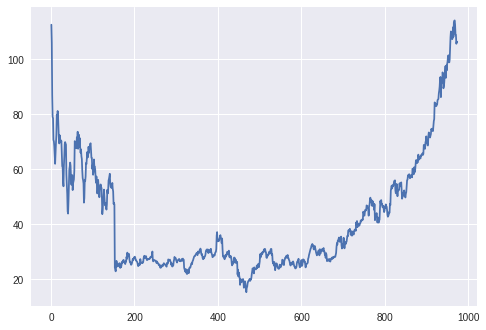

In [5]:
#simple graph of target data
plt.plot(df["Open"])

In [6]:
#final feature selection: choosing columns as features
features_LIST={0:'Volume', 1:'YY', 2:'MM', 3:'DD', 4:'INDEX', 5:'last_open', 6:'Date'}
selected=[0,1,2,3,4,5]
features_LIST=[features_LIST[i] for i in selected]
#printing selected features
print(" ".join(features_LIST))

Volume YY MM DD INDEX last_open


In [0]:
#splitting data into train test dataset. ts_ratio->Ratio of test proportion. order=Date-wise
ts_ratio=0.33
pnt=int(len(df)*(1-ts_ratio))
X_tr, X_ts, Y_tr, Y_ts = df[features_LIST][:pnt],df[features_LIST][pnt:],df[["Open"]][:pnt],df[["Open"]][pnt:]

In [0]:
#Bringing All values into a similar scale

#scaling all cols
from sklearn import preprocessing
Xscaler = preprocessing.MinMaxScaler().fit(X_tr)
X_tr,X_ts=Xscaler.transform(X_tr),Xscaler.transform(X_ts)

#scaling target variable
Yscaler = preprocessing.MinMaxScaler().fit(Y_tr)
Y_tr,Y_ts=Yscaler.transform(Y_tr),Yscaler.transform(Y_ts)

In [9]:
#Helper code to created a compiled keras model

from keras.models import *
from keras.layers import *

def modelBuilder(Layers_config=None,input_shape=None):
  """Return a complied model with the given setting"""
  
  if not Layers_config:#setting default layer config
    Layers_config={"layers":[(512,'relu'),(128,'relu'),(32,'relu')],"output_F":"linear"}

  if not input_shape:
    input_shape=[10]
    
  #fetching configs
  Layer_Sizes,F_activations=zip(*Layers_config['layers'])
  output_F_activation=Layers_config['output_F']
  withdrop=Layers_config.get("dropout",0)
  
  #Building the NN 
  model = Sequential()
  model.add(Dense(Layer_Sizes[0], kernel_initializer = 'uniform',  input_shape = input_shape))
  model.add(Activation(F_activations[0]))
  for i,l in enumerate(Layer_Sizes[1:]):
    model.add(Dense(l, kernel_initializer = 'uniform'))
    model.add(Activation(F_activations[i+1]))
    if withdrop:model.add(Dropout(withdrop))
  model.add(Dense(1, kernel_initializer = 'uniform'))
  model.add(Activation(output_F_activation))
  model.compile(optimizer='adam', loss='mse',metrics=['mse', 'accuracy'])

  return model



Using TensorFlow backend.


In [0]:
#Helper code to create evaluation on compiled model after training it on given data
def modelEval(model,X_train,X_test,Y_train,Y_test,epochs):
  "Train And Evaluate a pre-compiled model for given dataset. Return the measured errors and trained model itself"
  #dataSet
  X_tr,X_ts,Y_tr,Y_ts=np.array(X_train),np.array(X_test),np.array(Y_train),np.array(Y_test)

  #actual training
  metrics=model.fit(X_tr,Y_tr,epochs=epochs,verbose=0)

  #predict results
  pr_Y_ts = model.predict(X_ts)
  pr_Y_tr = model.predict(X_tr)
  
  #errors
  MSE_tr=np.mean((pr_Y_tr-Y_tr)**2)
  MSE_ts=np.mean((pr_Y_ts-Y_ts)**2)
  
  RMSE_tr=np.mean((pr_Y_tr-Y_tr)**2)**.5
  RMSE_ts=np.mean((pr_Y_ts-Y_ts)**2)**.5
  
  MAE_tr=np.mean(np.absolute(pr_Y_tr-Y_tr))
  MAE_ts=np.mean(np.absolute(pr_Y_ts-Y_ts))
  
  errors={"MSE":{"train":MSE_tr,"test":MSE_ts},"MAE":{"train":MAE_tr,"test":MAE_ts},"RMSE":{"train":RMSE_tr,"test":RMSE_ts},"model":model,"plot":[Y_tr,Y_ts,pr_Y_ts,pr_Y_tr]}
  return errors

In [0]:
#sample method, how to build and train a network with a specific config and data in simple 1 line

#eval=modelEval(modelBuilder({"layers":[(512,'relu'),(128,'relu'),(32,'relu')],"output_F":"linear"}),X_tr,X_ts,Y_tr,Y_ts,100)

In [0]:
#helper code to extract layers config information from a trained model object and format it with its errors into a pretty string

from functools import reduce
#extract layers info from `model`
activationsFromModel=lambda model:reduce((lambda l,r:l+"~" if r=="DD" else l+','+r),[x.get_config().get("activation","DD") for x in model.layers]).split(',')[1::2]
configFromModel=lambda model:list(zip([x.units for x in model.layers if hasattr(x,'units')],activationsFromModel(model)))
#format string representation of a model-layer's info
modelRepr=lambda model,joinee=", ",sep=".":joinee.join(["{}{}{}".format(n,sep,a) for n,a in configFromModel(model)])
#format string representation of error metrics from a evaluated model
eval2errorRepr=lambda evalo,joinee=" ":joinee.join(["{}={:3.4f},{:3.4f}".format(k,v['train'],v['test']) for k,v in evalo.items() if type(v)==type({})])
#format string representation of whole trained model with errors included
eval2str=lambda evalo:"[{1}]=>{0}".format(modelRepr(evalo['model'],":",""),eval2errorRepr(evalo))

#sample method to get a pretty string from a evaluated model
#eval2str(eval)

In [0]:
#helper code to generate models with combinations of different hyperparameters
TrainFor=lambda layers,output,epoch,dropout:modelEval(modelBuilder({"layers":[(LL,'relu') for LL in layers],"output_F":output,"dropout":dropout},input_shape=[X_tr.shape[1]]),X_tr,X_ts,Y_tr,Y_ts,epoch)
#a simple function that generate array with 
BinGen=lambda start,depth:[2**(int(__import__('math').log(start)/__import__('math').log(2))-i) for i in range(depth)]

In [14]:
#time consuming code (Takes around 7-8mins as it trains around 24 feed forward NN models on data of around 1.5k records)
%%time

models=[]
#generating various possible models

#BruteForcing hyperparameters
starters=[1024,512]#will tune no. of neurons
depths=[8,5,4]#will tune no. of layers
oplayers=["linear","sigmoid"]#will tune activation function of output layer
dropouts=[0,0.1]#will tune dropout of connections in network

for start in starters:
  for depth in depths:
    for op in oplayers:
      for drop in dropouts:
        models.append(TrainFor(BinGen(start,depth),output=op,epoch=100,dropout=drop))
        print('.',end='')
        
print('DoneTraining(s)')

........................DoneTraining(s)
CPU times: user 8min 20s, sys: 1min 5s, total: 9min 25s
Wall time: 7min 32s


In [15]:
#sorting models according to their performance
#then printing all of them and their errors
models=sorted(models,key=lambda eva:eva['MSE']['test'])
for m in models:
  print(eval2str(m))

[MSE=0.0004,0.0026 MAE=0.0119,0.0311 RMSE=0.0204,0.0511]=>512relu:256relu:128relu:64relu:32relu:1sigmoid
[MSE=0.0004,0.0030 MAE=0.0135,0.0364 RMSE=0.0209,0.0548]=>1024relu:512relu~:256relu~:128relu~:64relu~:1linear
[MSE=0.0004,0.0031 MAE=0.0131,0.0370 RMSE=0.0210,0.0554]=>1024relu:512relu~:256relu~:128relu~:1linear
[MSE=0.0005,0.0037 MAE=0.0141,0.0398 RMSE=0.0233,0.0606]=>1024relu:512relu:256relu:128relu:64relu:1linear
[MSE=0.0006,0.0044 MAE=0.0195,0.0557 RMSE=0.0249,0.0664]=>1024relu:512relu~:256relu~:128relu~:1sigmoid
[MSE=0.0005,0.0047 MAE=0.0152,0.0388 RMSE=0.0217,0.0686]=>512relu:256relu:128relu:64relu:1sigmoid
[MSE=0.0005,0.0048 MAE=0.0128,0.0429 RMSE=0.0213,0.0694]=>1024relu:512relu:256relu:128relu:64relu:32relu:16relu:8relu:1sigmoid
[MSE=0.0005,0.0064 MAE=0.0166,0.0489 RMSE=0.0228,0.0803]=>1024relu:512relu~:256relu~:128relu~:64relu~:32relu~:16relu~:8relu~:1sigmoid
[MSE=0.0004,0.0066 MAE=0.0120,0.0506 RMSE=0.0202,0.0812]=>512relu:256relu:128relu:64relu:32relu:1linear
[MSE=0.0005

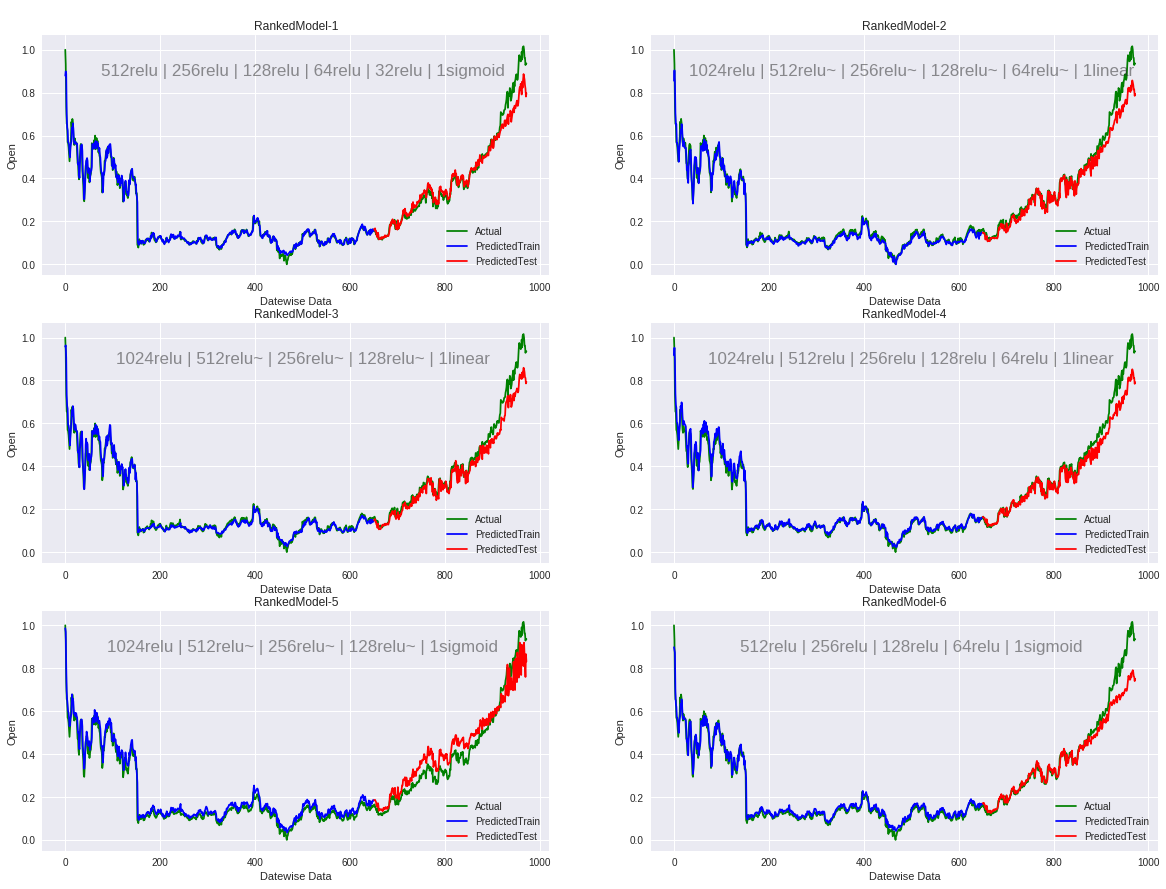

In [20]:
#Helper code to plot our data and different models' predictions.

def plotFromEval(evalobjs):
  """Plotting code: plotting all graphs from array of models"""
  #setting figure size in Fixed numbers acc. to number of graphs
  plt.figure(figsize=(20,5*((len(evalobjs)+1)//2)))
  #plotting each graph
  for i,evalobj in enumerate(evalobjs):
    #adding each graph at subplot
    plot=plt.subplot((len(evalobjs)+1)//2,2,i+1)
    #adding title of graph
    plot.set_title("\nRankedModel-{}".format(i+1))
    #adding model config on graph
    txt=modelRepr(evalobj['model']," | ","")
    plot.text(500,0.9,txt,ha='center',va='center',size=17,alpha=0.5)
    #plotting train,test,predicted on this subplot
    tr,ts,pts,ptr=evalobj['plot']
    trts=np.concatenate([tr,ts])
    plt.plot(range(len(trts)),trts,label="Actual",color='green')
    plt.plot(range(len(ptr)),ptr,label="PredictedTrain",color='blue')
    plt.plot(range(len(ptr),len(ptr)+len(pts)),pts,label="PredictedTest",color="red")
    #setting plot other properties
    plt.legend()
    plt.xlabel("Datewise Data")
    plt.ylabel("Open")
  #calling plt.show to display it then and there.
  return plt.show()

#plotting our top 6 models
plotFromEval(models[0:6])